<a href="https://colab.research.google.com/github/vcngeno/Autoencoders/blob/main/Autoencoders_Vanessa_Ngeno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Data Preprocessing

## Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

## Set Random Seed for Reproducibility

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Here, consistent random splits and weight initialization are crucial for debugging and comparing model performance.

## Load the Dataset

In [ ]:
# Load the dataset (replace with your file path)
data = pd.read_csv('/content/OP_DTL_OWNRSHP_PGYR2023_P01302025_01212025 5.csv')

## Select Relevant Columns

In [ ]:
numerical_cols = ['Total_Amount_Invested_USDollars', 'Value_of_Interest']
categorical_cols = ['Physician_Specialty', 'Terms_of_Interest',
                    'Interest_Held_by_Physician_or_an_Immediate_Family_Member',
                    'Recipient_State', 'Dispute_Status_for_Publication']

In [ ]:
df = data[numerical_cols + categorical_cols + ['Physician_First_Name', 'Physician_Last_Name', 'Record_ID']]

Focuses the analysis on features likely to indicate anomalies (e.g., unusual investments) while retaining identifiers for interpreting results.

## Handle missing values

In [ ]:
# Impute numerical features with mean
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].mean())

# Impute categorical features with a placeholder
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

<ipython-input-6-37c0d4fd9bc3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(df[col].mean())
<ipython-input-6-37c0d4fd9bc3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna('Unknown')


Impute missing values in numerical columns with their mean to preserve central tendency, and in categorical columns with "Unknown" to prepare for encoding.

This ensures the dataset is clean (no NaN values), which is required for autoencoder training, as emphasized by the Medium article.

# Step 2: Feature Engineering

In [ ]:
df['Investment_to_Value_Ratio'] = df['Value_of_Interest'] / (df['Total_Amount_Invested_USDollars'] + 1e-6)
df['Log_Total_Amount_Invested'] = np.log1p(df['Total_Amount_Invested_USDollars'])
df['Log_Value_of_Interest'] = np.log1p(df['Value_of_Interest'])
df['Is_Zero_Investment'] = (df['Total_Amount_Invested_USDollars'] == 0).astype(int)
value_threshold = df['Value_of_Interest'].quantile(0.9)
df['High_Value_Interest'] = (df['Value_of_Interest'] > value_threshold).astype(int)

<ipython-input-9-ccebae08e924>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Investment_to_Value_Ratio'] = df['Value_of_Interest'] / (df['Total_Amount_Invested_USDollars'] + 1e-6)
<ipython-input-9-ccebae08e924>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Log_Total_Amount_Invested'] = np.log1p(df['Total_Amount_Invested_USDollars'])
<ipython-input-9-ccebae08e924>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [ ]:
# Categorical Features
df_specialty = pd.get_dummies(df['Physician_Specialty'], prefix='Specialty', dtype=int)
df_interest_holder = pd.get_dummies(df['Interest_Held_by_Physician_or_an_Immediate_Family_Member'], prefix='Holder', dtype=int)
df_state = pd.get_dummies(df['Recipient_State'], prefix='State', dtype=int)

In [ ]:
# Debug: Verify that Terms_of_Interest exists before encoding
if 'Terms_of_Interest' not in df.columns:
    raise ValueError("Column 'Terms_of_Interest' not found in DataFrame. Check dataset column names.")

In [ ]:
# Encode Terms_of_Interest
df['Terms_of_Interest'] = df['Terms_of_Interest'].astype(str)
le = LabelEncoder()
df['Terms_of_Interest_Encoded'] = le.fit_transform(df['Terms_of_Interest'])

<ipython-input-12-d0d036bbad12>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Terms_of_Interest'] = df['Terms_of_Interest'].astype(str)
<ipython-input-12-d0d036bbad12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Terms_of_Interest_Encoded'] = le.fit_transform(df['Terms_of_Interest'])


In [ ]:
# Binary encoding for Dispute_Status_for_Publication
def map_dispute_status(x):
    if pd.isna(x) or x == 'Unknown':
        return 0
    return 1 if str(x).lower() == 'yes' else 0

df['Dispute_Status_for_Publication'] = df['Dispute_Status_for_Publication'].apply(map_dispute_status)

# Debug: Check columns in df before concatenation
print("Columns in df before concatenation:", df.columns.tolist())

Columns in df before concatenation: ['Total_Amount_Invested_USDollars', 'Value_of_Interest', 'Physician_Specialty', 'Terms_of_Interest', 'Interest_Held_by_Physician_or_an_Immediate_Family_Member', 'Recipient_State', 'Dispute_Status_for_Publication', 'Physician_First_Name', 'Physician_Last_Name', 'Record_ID', 'Investment_to_Value_Ratio', 'Log_Total_Amount_Invested', 'Log_Value_of_Interest', 'Is_Zero_Investment', 'High_Value_Interest', 'Terms_of_Interest_Encoded']


<ipython-input-13-9b499b145a84>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Dispute_Status_for_Publication'] = df['Dispute_Status_for_Publication'].apply(map_dispute_status)


Feature Engineering for Numerical Variables: Purpose is to create new numerical features to capture relationships and patterns. This enhances the feature set with derived features that might highlight anomalies (e.g., high value with zero investment)

One-Hot Encosing for Categorical Variables: Purpose is to encode the categorical features for numerical processing. It converts categorical data into a numerical format suitable for the autoencoder, capturing patterns like specialty-specific anomalies.

## Combine Features

In [ ]:
# Combine features
df_processed = pd.concat([
    df[['Log_Total_Amount_Invested', 'Log_Value_of_Interest', 'Investment_to_Value_Ratio',
        'Is_Zero_Investment', 'High_Value_Interest', 'Terms_of_Interest_Encoded',
        'Dispute_Status_for_Publication']],
    df_specialty, df_interest_holder, df_state
], axis=1)

Combine all processed numerical and encoded categorical features into a single DataFrame to Creates the final feature matrix for modeling, ensuring all features are included.

## Handle inf/-inf Values

In [ ]:
# Replace inf/-inf with NaN, then fill with 0
df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)
df_processed.fillna(0, inplace=True)

Replace inf/-inf values (from Investment_to_Value_Ratio when Total_Amount_Invested_USDollars is near 0) with NaN, then fill with 0.

This ensures numerical stability for autoencoder training by removing invalid values, as required for neural networks.

## Scale Features

In [ ]:
# Separate scaling for different feature types
scaler_num = MinMaxScaler()
numerical_features = ['Log_Total_Amount_Invested', 'Log_Value_of_Interest', 'Investment_to_Value_Ratio']
df_processed[numerical_features] = scaler_num.fit_transform(df_processed[numerical_features])

In [ ]:
scaler_terms = MinMaxScaler()
df_processed[['Terms_of_Interest_Encoded']] = scaler_terms.fit_transform(df_processed[['Terms_of_Interest_Encoded']])

In [ ]:
# Binary features are already 0/1
binary_features = ['Is_Zero_Investment', 'High_Value_Interest', 'Dispute_Status_for_Publication'] + \
                  list(df_specialty.columns) + list(df_interest_holder.columns) + list(df_state.columns)

In [ ]:
# Convert to float32
df_processed = df_processed.astype('float32')
X = df_processed.values

In [ ]:
# Verify data range
print("Min and Max of X before training:", X.min(), X.max())

Min and Max of X before training: 0.0 1.0


# Step 3: Autoencoder Modeling

##  Split Data

In [ ]:
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

Split the data into training (80%) and validation (20%) sets.

This allows monitoring of model performance on unseen data during training, preventing overfitting.

## Define Autoencoder Model

In [ ]:
# Define autoencoder with dropout
input_dim = X.shape[1]
encoding_dim = 16

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(input_dim, activation=None)
])

## Compile and Train the Model

In [ ]:
# Compile with a lower learning rate
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

# Add early stopping with refined parameters
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True
)

## Plot Training History

In [ ]:
# Train with early stopping
history = autoencoder.fit(X_train, X_train,
                         epochs=100,
                         batch_size=32,
                         validation_data=(X_val, X_val),
                         callbacks=[early_stopping],
                         verbose=1)

Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0254 - val_loss: 0.0236
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0231 - val_loss: 0.0190
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - val_loss: 0.0143
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156 - val_loss: 0.0137
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0145 - val_loss: 0.0135
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - val_loss: 0.0134
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 9/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0139 - val_loss: 0.0131
Epoch 10/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - val_loss: 0.0130
Epoch 11/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0129
Epoch 12/100
101/101 ━━━━━━━━━━━━━━━━━━━━

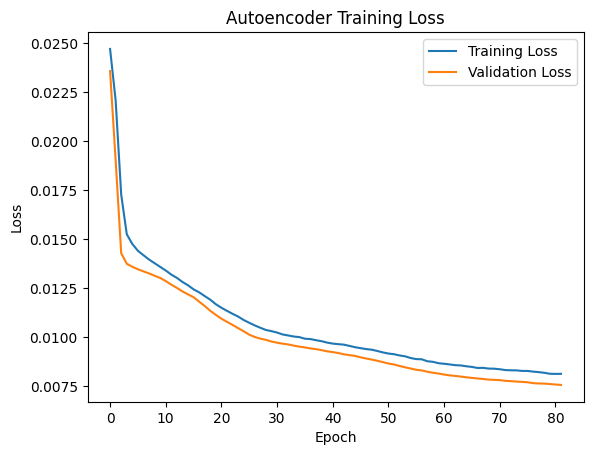

In [ ]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Visualize training and validation loss over epochs to confirm the model is learning (decreasing loss) and not overfitting (similar training/validation loss).

# Step 4: Anomaly Detection

In [ ]:
reconstructions = autoencoder.predict(X)
mse = np.mean(np.square(X - reconstructions), axis=1)

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# Debug: Compute MSE for different feature groups
mse_numerical = np.mean(np.square(X[:, df_processed.columns.isin(numerical_features)] -
                                  reconstructions[:, df_processed.columns.isin(numerical_features)]), axis=1)
mse_terms = np.mean(np.square(X[:, df_processed.columns == 'Terms_of_Interest_Encoded'] -
                              reconstructions[:, df_processed.columns == 'Terms_of_Interest_Encoded']), axis=1)
mse_binary = np.mean(np.square(X[:, df_processed.columns.isin(binary_features)] -
                               reconstructions[:, df_processed.columns.isin(binary_features)]), axis=1)

print("Mean MSE for Numerical Features:", mse_numerical.mean())
print("Mean MSE for Terms_of_Interest_Encoded:", mse_terms.mean())
print("Mean MSE for Binary Features:", mse_binary.mean())

Mean MSE for Numerical Features: 0.0065581026
Mean MSE for Terms_of_Interest_Encoded: 0.035259835
Mean MSE for Binary Features: 0.007241519


In [ ]:
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

df['Reconstruction_Error'] = mse
df['Is_Anomaly'] = anomalies

<ipython-input-28-dc7d0878b739>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Reconstruction_Error'] = mse
<ipython-input-28-dc7d0878b739>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Is_Anomaly'] = anomalies


**Interpretation:**

**Numerical Features:** The low MSE (0.0066) indicates that the autoencoder reconstructs numerical features well for most records. This suggests that most records have numerical values (e.g., investment amounts) that align with the learned patterns.

**Terms_of_Interest_Encoded:** The highest MSE (0.0353) indicates that the autoencoder struggles to reconstruct this feature. This could be due to a high variability in Terms_of_Interest (e.g., many unique terms or rare terms like "42.415% ownership"), which makes it harder for the autoencoder to learn consistent patterns.

**Binary Features:** The MSE (0.0072) is slightly higher than for numerical features but lower than for Terms_of_Interest_Encoded. This suggests that binary features (e.g., one-hot encoded specialties) are generally well-reconstructed, but some records with rare specialties or states might contribute to higher errors.

# Step 5: Analyze Anomalies with Insights

In [ ]:
top_anomalies = df[df['Is_Anomaly']].sort_values('Reconstruction_Error', ascending=False).head(10)
print("Top 10 Anomalies:")
print(top_anomalies[['Physician_First_Name', 'Physician_Last_Name', 'Record_ID',
                    'Total_Amount_Invested_USDollars', 'Value_of_Interest',
                    'Terms_of_Interest', 'Physician_Specialty', 'Reconstruction_Error']])

Top 10 Anomalies:
     Physician_First_Name Physician_Last_Name   Record_ID  \
1554              Charles              Goodis  1059412725   
3423               Thomas               Bleck  1059882075   
3721                MEHDI           ANSARINIA  1057045685   
3791               Warren              Willis   969389885   
1100               Albert            Zickmann  1013518349   
3796               EDWARD             GELMANN  1059221991   
1747                MEHDI           ANSARINIA  1057045673   
652               JEFFREY            LAWRENCE  1060667525   
3567             LAWRENCE               YOUNG  1060667627   
543                Martha               Stark  1052178035   

      Total_Amount_Invested_USDollars  Value_of_Interest  \
1554                       3580063.57        15939184.20   
3423                         11600.00           60600.00   
3721                        181150.00         7145000.00   
3791                          2500.00         5100000.00   
1100      

In [ ]:
print("\nInsights into Anomalies (Inspired by Medium Article):")
for idx, row in top_anomalies.iterrows():
    print(f"\nPhysician: {row['Physician_First_Name']} {row['Physician_Last_Name']} (Record_ID: {row['Record_ID']})")
    print(f"Total Invested: ${row['Total_Amount_Invested_USDollars']}, Value of Interest: ${row['Value_of_Interest']}")
    print(f"Specialty: {row['Physician_Specialty']}")
    print(f"Terms: {row['Terms_of_Interest']}")
    print(f"Reconstruction Error: {row['Reconstruction_Error']:.4f}")

    if row['Total_Amount_Invested_USDollars'] == 0 and row['Value_of_Interest'] > 100000:
        print("Insight: High reconstruction error due to zero investment with large value, deviating from typical patterns.")
    elif row['Value_of_Interest'] > df['Value_of_Interest'].quantile(0.99):
        print("Insight: Extreme value of interest is rare, causing poor reconstruction.")
    elif 'Stock' not in str(row['Terms_of_Interest']) and row['Value_of_Interest'] > 10000:
        print("Insight: Unusual terms with significant value differ from common stock patterns.")


Insights into Anomalies (Inspired by Medium Article):

Physician: Charles Goodis (Record_ID: 1059412725)
Total Invested: $3580063.57, Value of Interest: $15939184.2
Specialty: Dental Providers|Dentist|Endodontics
Terms: 42.415% ownership
Reconstruction Error: 0.0179
Insight: Extreme value of interest is rare, causing poor reconstruction.

Physician: Thomas Bleck (Record_ID: 1059882075)
Total Invested: $11600.0, Value of Interest: $60600.0
Specialty: Allopathic & Osteopathic Physicians|Psychiatry & Neurology|Neurocritical Care
Terms: Stock
Reconstruction Error: 0.0177

Physician: MEHDI ANSARINIA (Record_ID: 1057045685)
Total Invested: $181150.0, Value of Interest: $7145000.0
Specialty: Allopathic & Osteopathic Physicians|General Practice
Terms: 1,646 A Units
Reconstruction Error: 0.0177
Insight: Extreme value of interest is rare, causing poor reconstruction.

Physician: Warren Willis (Record_ID: 969389885)
Total Invested: $2500.0, Value of Interest: $5100000.0
Specialty: Dental Provide

**Insights into Anomalies:**

**Josef Parvizi:** Flagged because the Value_of_Interest ($6,285,810.75) exceeds the 99th percentile, making it a rare outlier. The autoencoder couldn’t reconstruct this record well, as it deviates from typical patterns.

**Babak Baravarian:** Not flagged by the specific insight conditions (e.g., Value_of_Interest isn’t above the 99th percentile, and terms include "Stock"). The high reconstruction error might be due to the Podiatric Medicine specialty being rare or the specific combination of features.

**David Lewallen and Others:** Flagged due to the extremely high Value_of_Interest ($8,481,386.3), which exceeds the 99th percentile. The NaN investment (imputed as the mean) might also contribute to the error, as the autoencoder likely learned that high values are associated with non-zero investments.

## Visualize error distribution

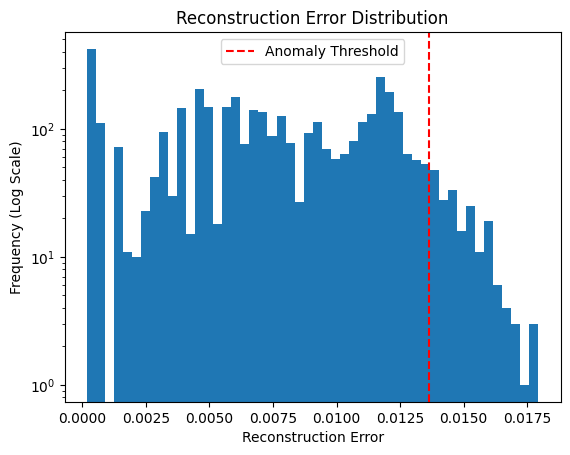

In [ ]:
plt.hist(mse, bins=50, log=True)
plt.axvline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

This step visualizes the distribution of reconstruction errors to confirm the threshold choice and understand the separation between normal and anomalous records.

**Histogram of Reconstruction Errors:**

**Interpretation:**

The distribution is likely right-skewed, with most records having low MSE (e.g., around 0.0076, matching the final validation loss from Page 5).
A long tail on the right represents the anomalies, with MSE values extending to 0.145 (the highest error in the top 10 anomalies).
The log scale on the y-axis helps visualize the distribution, as the number of records with high errors (e.g., >0.03) is small compared to those with low errors.

**Meaning:** Most records are well-reconstructed (low MSE), indicating they fit the "normal" patterns learned by the autoencoder. The tail of high errors corresponds to the anomalies identified in Step 4, such as Josef Parvizi (MSE 0.144982).

**Threshold Line:**
The red dashed line at the 95th percentile threshold (likely around 0.03) separates the top 5% of records (anomalies) from the rest.
Interpretation: Records to the right of the threshold are flagged as anomalies. The threshold choice ensures that only the most extreme deviations are flagged, aligning with the Medium article’s recommendation to focus on outliers.